## Loading Libraries and Extracting Dataset

In [6]:
#Basic
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd
import zipfile

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

datasetzipfile = "datasets.zip"

# Check if the zip file exists
if os.path.exists(datasetzipfile):
    # Open the zip file in read mode
    with zipfile.ZipFile(datasetzipfile, 'r') as zip_ref:
        # Iterate through each file in the zip archive
        for file_info in zip_ref.infolist():
            # Check if the file already exists in the current directory
            if not os.path.exists(file_info.filename):
                zip_ref.extract(file_info)
else:
    print(f"{datasetzipfile} does not exist.")

train_path_dog = "datasets/train/dog"
train_path_cat = "datasets/train/cat"
valid_path_dog = "datasets/val/dog"
valid_path_cat = "datasets/val/cat"

test_path = "datasets/test"

#Count the Data Provided
def count_files_in_directory(path):
    try:
        # List all entries in the specified directory
        all_entries = os.listdir(path)
        
        # Count only the files (exclude directories)
        total_files = sum(1 for entry in all_entries if os.path.isfile(os.path.join(path, entry)))
        
        return total_files
    except Exception as e:
        return str(e)

# Specify the directory path
print("Total number of dog images in training data :", count_files_in_directory(train_path_dog))
print("Total number of cat images in training data :", count_files_in_directory(train_path_cat))
print()
print("Total number of dog images in validation data :", count_files_in_directory(valid_path_dog))
print("Total number of cat images in validation data :", count_files_in_directory(valid_path_cat))
print()
print("Total number of unknown images in test data :", count_files_in_directory(test_path))

Total number of dog images in training data : 10000
Total number of cat images in training data : 10000

Total number of dog images in validation data : 2500
Total number of cat images in validation data : 2500

Total number of unknown images in test data : 500


## Data Exploration

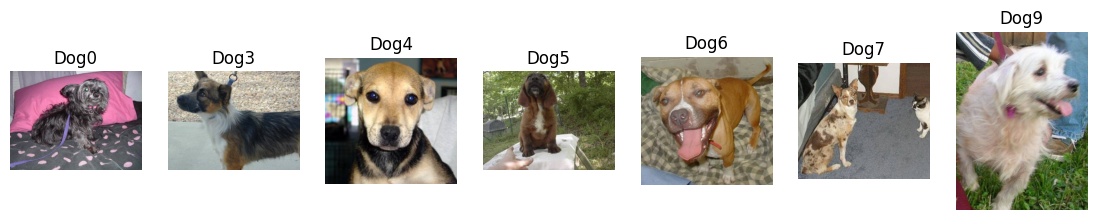

In [7]:
#Visualise Images of Dogs from Train Dataset

plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.4)

# Initialize a counter for the number of images plotted
count = 0

for i in range(10):
    filename = f'{train_path_dog}/dog.{i}.jpg'
    
    # Check if the file exists
    if os.path.exists(filename):
        plt.subplot(1, 10, count + 1)  # Create a subplot for the existing image
        image = imread(filename)
        plt.imshow(image)
        plt.title('Dog' + str(i), fontsize=12)
        plt.axis('off')
        
        count += 1  # Increment the counter for each plotted image

# Adjust the layout to accommodate the images
plt.show()

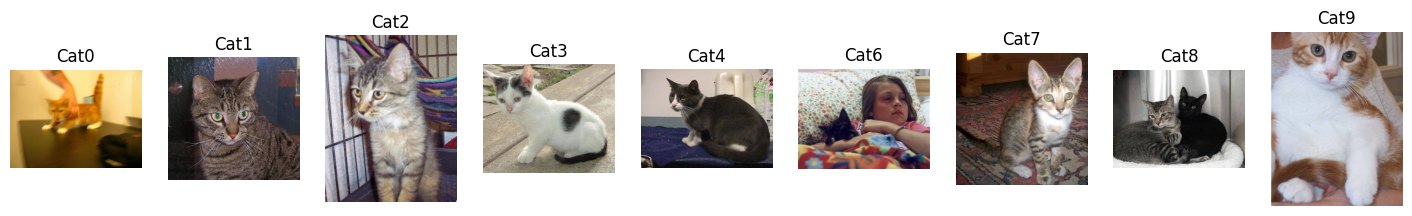

In [8]:
#Visualise Images of Cats from Train Dataset

plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.4)

# Initialize a counter for the number of images plotted
count = 0

for i in range(10):
    filename = f'{train_path_cat}/cat.{i}.jpg'
    
    # Check if the file exists
    if os.path.exists(filename):
        plt.subplot(1, 10, count + 1)  # Create a subplot for the existing image
        image = imread(filename)
        plt.imshow(image)
        plt.title('Cat' + str(i), fontsize=12)
        plt.axis('off')
        
        count += 1  # Increment the counter for each plotted image

# Adjust the layout to accommodate the images
plt.show()

## MobileNetV2 Model

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Model Summary
--------------
CNN Model: MobileNetV2


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,286,401 (39.24 MB)

 Trainable params: 8,028,417 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None

Data generators are created.
Early stopping and learning rate reduction callbacks are set.



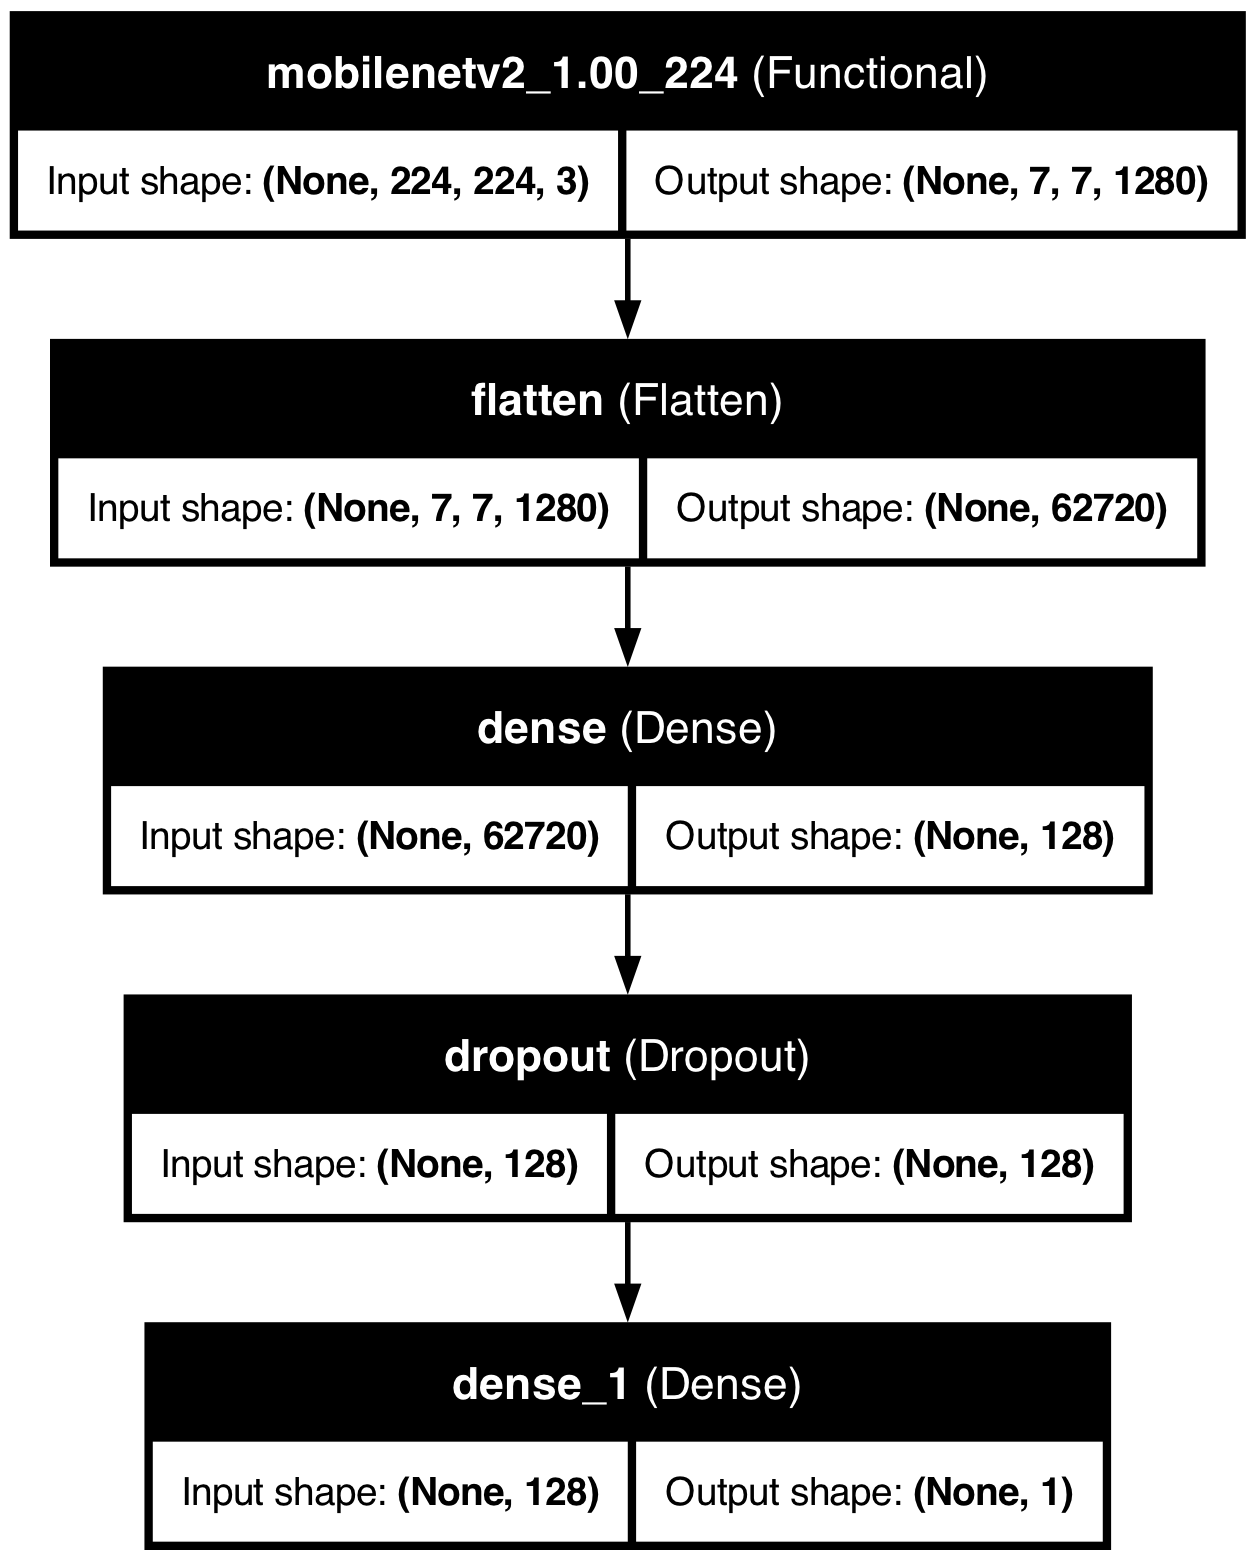

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image

# Paths to training and validation directories
train_path = "datasets/train"
valid_path = "datasets/val"

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Data generators for loading images from directories
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Function to create the model
"""Build and compile the MobileNetV2 model."""
# Load MobileNetV3Large with ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Model Summary")
print("--------------")
print("CNN Model: MobileNetV2")
print(model.summary())

# Callbacks for learning rate reduction and early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

print()
print("Data generators are created.")
print("Early stopping and learning rate reduction callbacks are set.")
print()

# Save the model architecture as an image
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the model architecture
Image.open('model_architecture.png')

## Model Training

In [10]:
# Set the number of runs
n_runs = 5
val_acc_results = []
val_loss_results = []

for run in range(n_runs):
    
    # Train the model
    history = model.fit(train_generator, 
                        validation_data=valid_generator,
                        epochs=25,
                        callbacks=[early_stop, reduce_lr])
    
    # Evaluate and store the validation accuracy
    val_loss, val_acc = model.evaluate(valid_generator)
    val_acc_results.append(val_acc)
    val_loss_results.append(val_loss)

    print("Run " + str(run+1) + " Results:")
    print(f"Validation accuracy: {val_acc:.4f}")
    print(f"Validation loss: {val_loss:.4f}")
    print()

/Users/mkabilan/Desktop/Mini-Proj.nosync/myenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 386s 616ms/step - accuracy: 0.9288 - loss: 0.7842 - val_accuracy: 0.9764 - val_loss: 0.0609 - learning_rate: 0.0010
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 536s 858ms/step - accuracy: 0.9604 - loss: 0.1063 - val_accuracy: 0.9834 - val_loss: 0.0489 - learning_rate: 0.0010
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 462s 738ms/step - accuracy: 0.9667 - loss: 0.0903 - val_accuracy: 0.9824 - val_loss: 0.0523 - learning_rate: 0.0010
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 400s 640ms/step - accuracy: 0.9625 - loss: 0.0881 - val_accuracy: 0.9790 - val_loss: 0.0602 - learning_rate: 0.0010
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 414s 662ms/step - accuracy: 0.9688 - loss: 0.0857 - val_accuracy: 0.9796 - val_loss: 0.0583 - learning_rate: 0.0010
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 560s 896ms/step - accuracy: 0.9712 - loss: 0.0721 - val_accuracy: 0.9826 - val_loss: 0.0444 - learning_rate: 2.0000e-04
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 518s 829ms/step - ac

## Average Accuracy and Loss

In [11]:
# Calculate and print average results
average_val_acc = np.mean(val_acc_results)
average_val_loss = np.mean(val_loss_results)

print("Average Results:")
print(f"Average Validation Accuracy: {average_val_acc:.4f}")
print(f"Average Validation Loss: {average_val_loss:.4f}")

Average Results:
Average Validation Accuracy: 0.9821
Average Validation Loss: 0.0468


## Submission CSV

In [12]:
# Initialize an empty list to hold the results
results = []

# Loop through each file in the test directory
for img_file in os.listdir(test_path):
    # Load and preprocess the image
    img_path = os.path.join(test_path, img_file)
    img = image.load_img(img_path, target_size=(224, 224))  # Size should match input size of the model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale to match training preprocessing

    # Make a prediction
    prediction = model.predict(img_array)
    # If prediction >= 0.5, it's a dog (1); otherwise, it's a cat (0)
    prediction_label = 1 if prediction >= 0.5 else 0
    
    # Append the filename and prediction to the results list
    results.append([os.path.splitext(img_file)[0], prediction_label])

# Create a DataFrame for the results
df = pd.DataFrame(results, columns=['id', 'label'])

# Save the results to a CSV file
df.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

## Extracting CIFAR-10 Dataset

Extraction completed.


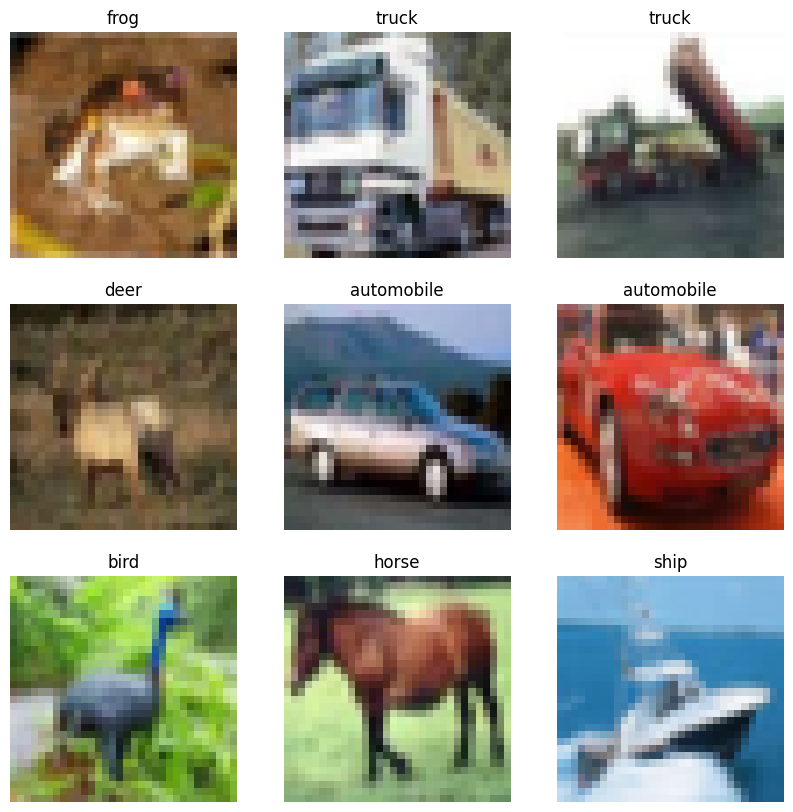

In [17]:
import tarfile
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to the CIFAR-10 tar file
tar_file_path = 'cifar-10-python.tar'

# Extract the tar file
with tarfile.open(tar_file_path, 'r:') as tar:
    tar.extractall()
    print("Extraction completed.")

# Path to the extracted CIFAR-10 data
cifar10_data_path = './cifar-10-batches-py/'

# Function to load a batch of CIFAR-10 data
def load_cifar_batch(filename):
    with open(filename, 'rb') as file:
        batch = pickle.load(file, encoding='latin1')
        images = batch['data']
        labels = batch['labels']
        # CIFAR-10 images are 32x32 with 3 channels
        images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        return images, labels

# Load a batch of CIFAR-10 data for viewing
batch_file = os.path.join(cifar10_data_path, 'data_batch_1')
images, labels = load_cifar_batch(batch_file)

# CIFAR-10 classes
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]

# Display some sample images with their labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(cifar10_classes[labels[i]])
    plt.axis('off')
plt.show()


## Modified MobileNetV2 for CIFAR-10 Dataset

In [18]:
import tarfile
import pickle
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

# Path to CIFAR-10 tar file
tar_file_path = 'cifar-10-python.tar'

# Extract the tar file
with tarfile.open(tar_file_path, 'r:') as tar:
    tar.extractall()
    print("Extraction completed.")

# Path to extracted CIFAR-10 data
cifar10_data_path = './cifar-10-batches-py/'

# Load CIFAR-10 batches
def load_cifar_data(data_path):
    images, labels = [], []
    for i in range(1, 6):  # CIFAR-10 has 5 training batches
        with open(f"{data_path}data_batch_{i}", 'rb') as file:
            batch = pickle.load(file, encoding='latin1')
            images.append(batch['data'])
            labels.extend(batch['labels'])
    images = np.concatenate(images)
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to (32, 32, 3)
    return images, np.array(labels)

# Load training and test data
X_train, y_train = load_cifar_data(cifar10_data_path)
with open(f"{cifar10_data_path}test_batch", 'rb') as file:
    test_batch = pickle.load(file, encoding='latin1')
    X_test = test_batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_test = np.array(test_batch['labels'])

# Normalize pixel values
X_train, X_test = X_train / 255.0, X_test / 255.0

# Convert labels to categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Build MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for learning rate reduction and early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")


Extraction completed.


/var/folders/_3/62_s5hc57jx7dkvrvcbg_x1w0000gn/T/ipykernel_27820/889321116.py:52: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.2545 - loss: 2.0501 - val_accuracy: 0.3232 - val_loss: 1.8589 - learning_rate: 0.0010
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.3219 - loss: 1.8595 - val_accuracy: 0.3248 - val_loss: 1.8293 - learning_rate: 0.0010
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.3309 - loss: 1.8389 - val_accuracy: 0.3358 - val_loss: 1.8117 - learning_rate: 0.0010
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.3434 - loss: 1.8101 - val_accuracy: 0.3416 - val_loss: 1.7987 - learning_rate: 0.0010
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.3472 - loss: 1.7978 - val_accuracy: 0.3430 - val_loss: 1.7896 - learning_rate: 0.0010
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.3497 - loss: 1.7846 - val_accuracy: 0.3446 - val_loss: 1.7832 - learning_rate: 0.0010
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accura

In [2]:
import tarfile
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Path to CIFAR-10 tar file
tar_file_path = 'cifar-10-python.tar'

# Extract the tar file
with tarfile.open(tar_file_path, 'r:') as tar:
    tar.extractall()
    print("Extraction completed.")

# Path to extracted CIFAR-10 data
cifar10_data_path = './cifar-10-batches-py/'

# Load CIFAR-10 batches
def load_cifar_data(data_path):
    images, labels = [], []
    for i in range(1, 6):  # CIFAR-10 has 5 training batches
        with open(f"{data_path}data_batch_{i}", 'rb') as file:
            batch = pickle.load(file, encoding='latin1')
            images.append(batch['data'])
            labels.extend(batch['labels'])
    images = np.concatenate(images)
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to (32, 32, 3)
    return images, np.array(labels)

# Load training and test data
X_train, y_train = load_cifar_data(cifar10_data_path)
with open(f"{cifar10_data_path}test_batch", 'rb') as file:
    test_batch = pickle.load(file, encoding='latin1')
    X_test = test_batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_test = np.array(test_batch['labels'])

# Normalize pixel values
X_train, X_test = X_train / 255.0, X_test / 255.0

# Convert labels to categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Resize images to a higher resolution for MobileNetV2
X_train = tf.image.resize(X_train, (96, 96))
X_val = tf.image.resize(X_val, (96, 96))
X_test = tf.image.resize(X_test, (96, 96))

# Data Augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1
)
datagen.fit(X_train)

# Build MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = True

# Fine-tune by freezing early layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Use label smoothing in loss
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-5),
              loss=loss, metrics=['accuracy'])

# Callbacks for learning rate reduction and early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")


Extraction completed.


: 